# Dataset Collection

In [1]:
import pandas as pd
import numpy as np

In [2]:
#location outside of repository for string for my api key for weather world online api
#https://www.worldweatheronline.com/developer/
#if you are reproducing, replace "key" with your key string
keyfile = '../../apikeys/weathertrialkey.txt'
with open(keyfile) as f:
    key = f.readlines()[0]

In [3]:
#location outside of repository for storing and retriveing csv data

In [4]:
from wwo_hist import retrieve_hist_data

In [5]:
#daily for a month
FREQUENCY = 24
START_DATE = '1-NOV-2021'
END_DATE = '30-NOV-2021'
API_KEY = key
LOCATION_LIST = ['76019']

dailydata = retrieve_hist_data(API_KEY,
                                LOCATION_LIST,
                                START_DATE,
                                END_DATE,
                                FREQUENCY,
                                location_label = False,
                                export_csv = True,
                                store_df = True)



Retrieving weather data for 76019


Currently retrieving data for 76019: from 2021-11-01 to 2021-11-30
Time elapsed (hh:mm:ss.ms) 0:00:00.965453


export 76019 completed!




In [6]:
#hourly for a week
FREQUENCY = 1
START_DATE = '21-NOV-2021'
END_DATE = '27-NOV-2021'
API_KEY = key
LOCATION_LIST = ['76019']

hourlydata = retrieve_hist_data(API_KEY,
                                LOCATION_LIST,
                                START_DATE,
                                END_DATE,
                                FREQUENCY,
                                location_label = False,
                                export_csv = True,
                                store_df = True)



Retrieving weather data for 76019


Currently retrieving data for 76019: from 2021-11-21 to 2021-11-27
Time elapsed (hh:mm:ss.ms) 0:00:00.371214


export 76019 completed!




## Datasets

In [190]:
daily = dailydata[0][['date_time', 'tempC']]

In [191]:
set0 = [int(i) for i in daily['tempC']]

In [192]:
hourly = hourlydata[0][['date_time', 'tempC']]

In [193]:
set1 = [int(i) for i in hourly['tempC']]

# Interpolation Method Code

## Legrange Method

In [194]:
#function for individual legrange interpolation for each point
def legrange_interpolate(x, x_values, y_values):
    def _basis(j):
        p = [(x - x_values[m])/(x_values[j] - x_values[m]) for m in range(k) if m != j]
        return np.prod(p)
    k = len(x_values)
    return sum(_basis(j)*y_values[j] for j in range(k))

### Legrange Implementation

In [240]:
daily_interpolation0 = []
_set = set0
_n = len(_set)
for x in range(0, _n, 1):
    daily_interpolation0.append(legrange_interpolate(x, [i for i in range(0, _n, 2)], [_set[i] for i in range(0, _n, 2)]))

In [196]:
hourly_interpolation0 = []
_set = set1
_n = len(_set)
for x in range(0, _n, 1):
    hourly_interpolation0.append(legrange_interpolate(x, [i for i in range(0, _n, 2)], [_set[i] for i in range(0, _n, 2)]))

## Neuton Method

In [197]:
def NDD(x,y):
    n = len(x)
    A = np.zeros((n,n+1))
    A[:,0]= x[:]
    A[:,1]= y[:]
    for j in range(2,n+1):
        for i in range(j-1,n):
            A[i,j] = (A[i,j-1]-A[i-1,j-1]) / (A[i,0]-A[i-j+1,0])
    p = np.zeros(n)
    for k in range(0,n):
        p[k] = A[k,k+1]
    return p
def newton_polynomial(t,x,p):
    n = len(x)
    out = p[n-1]
    for i in range(n-2,-1,-1):
        out = out*(t-x[i]) + p[i]
    return out

### Neuton Implementation

In [237]:
daily_interpolation1 = []
_set = set0
_n = len(_set)
_coeff = NDD([i for i in range(0, _n, 2)], [_set[i] for i in range(0, _n, 2)])
for x in range(0, _n, 1):
    daily_interpolation1.append(newton_polynomial(x, [i for i in range(0, _n, 2)], _coeff))

In [199]:
hourly_interpolation1 = []
_set = set1
_n = len(_set)
_coeff = NDD([i for i in range(0, 30, 2)], [set0[i] for i in range(0, 30, 2)])
for x in range(0, 30, 1):
    daily_interpolation1.append(newton_polynomial(x, [i for i in range(0, 30, 2)], _coeff))

# Results

In [200]:
import matplotlib.pyplot as plt

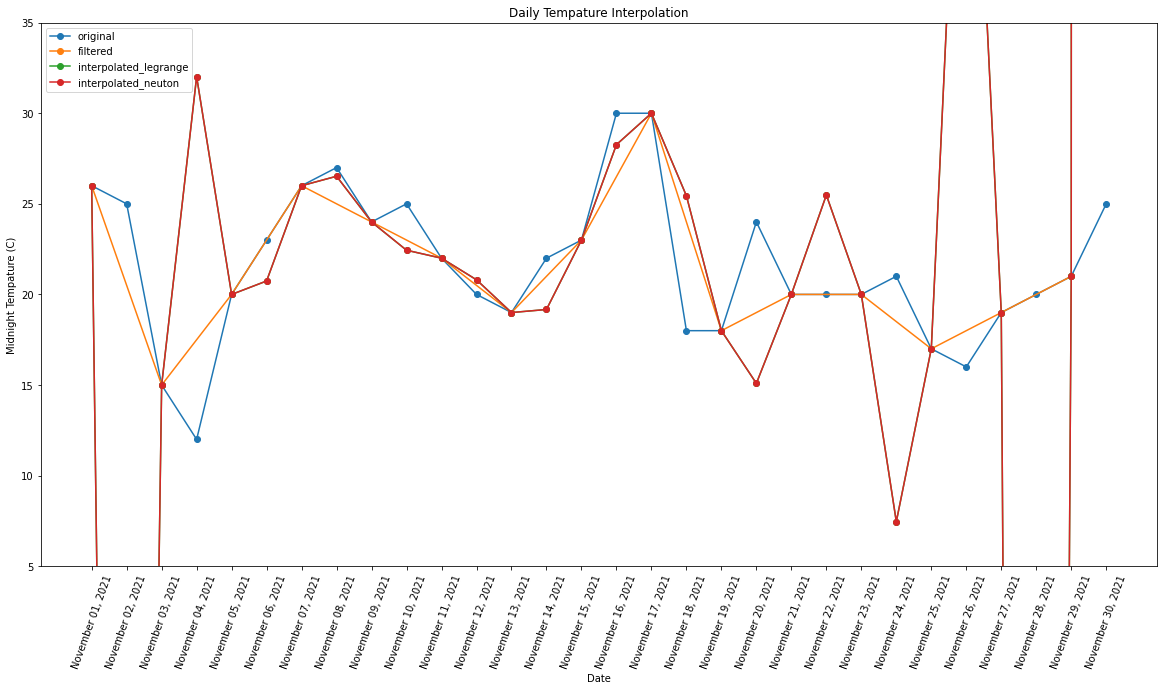

In [290]:
plt.figure(figsize = (20, 10))
plt.plot(range(len(daily.tempC)), [int(i) for i in  daily['tempC'].to_list()], marker = 'o', label = 'original')
plt.plot([i for i in range(0, 30, 2)], [set0[i] for i in range(0, 30, 2)], marker='o', label = 'filtered')
plt.plot([i for i in range(len(daily_interpolation0))], daily_interpolation0, marker='o', label = 'interpolated_legrange')
plt.plot([i for i in range(len(daily_interpolation1))], daily_interpolation1, marker='o', label = 'interpolated_neuton')
plt.ylim(5, 35)
plt.xticks(range(len(daily.tempC)), [i.strftime('%B %d, %Y') for i in daily['date_time'].to_list()], rotation=70)
plt.xlabel('Date')
plt.ylabel('Midnight Tempature (C)')
plt.title('Daily Tempature Interpolation')
plt.legend()
plt.show()

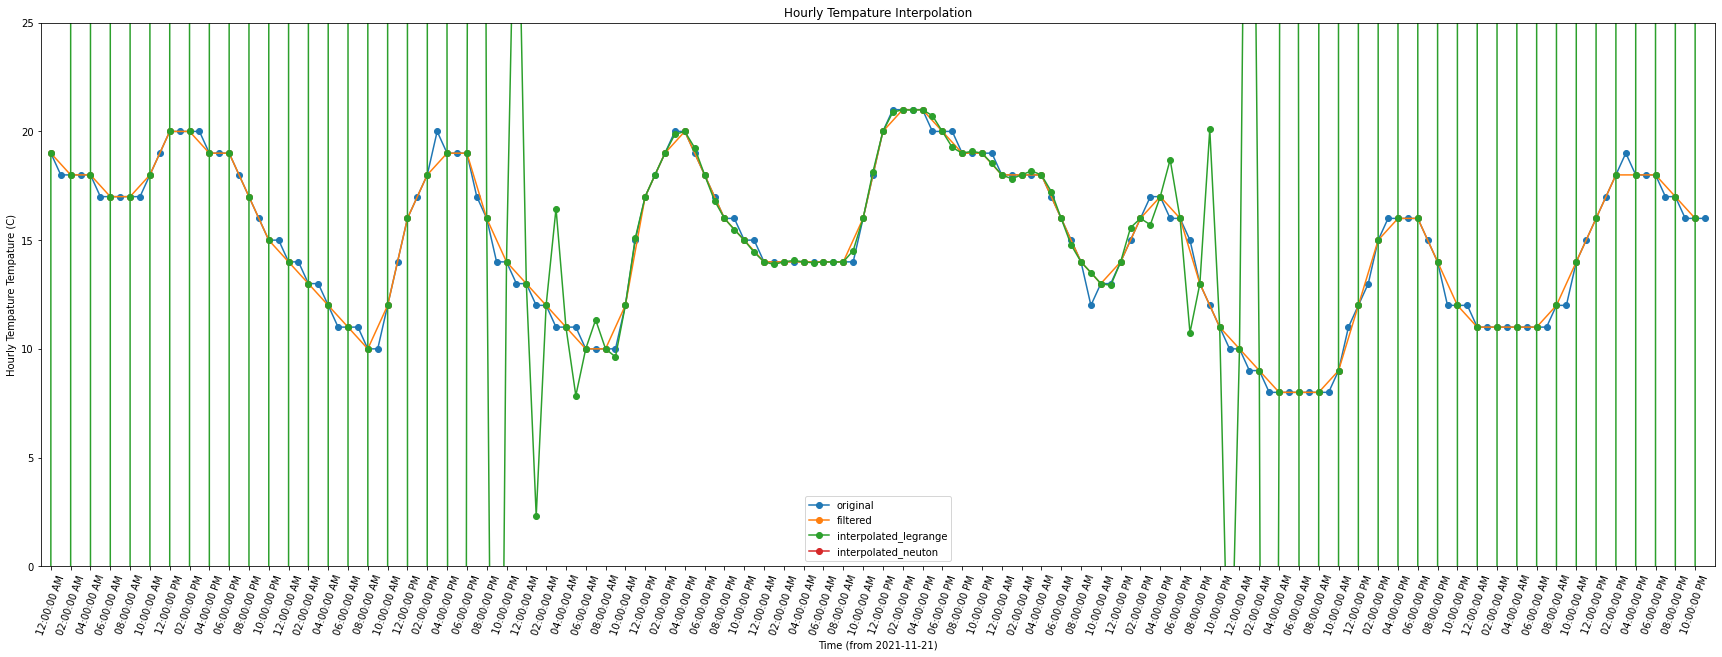

In [296]:
plt.figure(figsize = (30, 10))
plt.plot(range(len(hourly.tempC)), [int(i) for i in hourly['tempC'].to_list()], marker = 'o', label = 'original')
plt.plot([i for i in range(0, len(set1), 2)], [set1[i] for i in range(0, len(set1), 2)], marker='o', label = 'filtered')
plt.plot([i for i in range(len(hourly_interpolation0))], hourly_interpolation0, marker='o', label = 'interpolated_legrange')
plt.plot([i for i in range(len(hourly_interpolation1))], hourly_interpolation1, marker='o', label = 'interpolated_neuton')
plt.ylim(0, 25)
plt.xlim(-1, len(hourly.tempC))
plt.xticks(range(0, len(hourly.tempC), 2), [[i.strftime('%r') for i in hourly['date_time'].to_list()][i] for i in range(0, len(hourly.tempC), 2)], rotation=70)
plt.xlabel('Time (from 2021-11-21)')
plt.ylabel('Hourly Tempature Tempature (C)')
plt.title('Hourly Tempature Interpolation')
plt.legend()
plt.show()